In [2]:
import mlrose_hiive as mlrose
import pandas as pd
import numpy as np
import joblib
from tqdm import tqdm
import time

import sklearn

import matplotlib.pyplot as plt
import seaborn as sns

from mlrose_hiive.fitness._discrete_peaks_base import _DiscretePeaksBase

In [3]:
""" Classes for defining optimization problem objects."""

import numpy as np

from mlrose_hiive import DiscreteOpt, FourPeaks


class FourPeaksGenerator:
    """Generator class for Four Peaks."""
    @staticmethod
    def generate(seed, size=20, t_pct=0.1):
        np.random.seed(seed)
        fitness = FourPeaks(t_pct=t_pct)
        problem = DiscreteOpt(length=size, fitness_fn=fitness, maximize=True)
        return problem

In [4]:
from mlrose_hiive import RHCRunner

In [5]:
problem_size = 100 #refers to how long the bit string will be 
fourpeaks_problem = FourPeaksGenerator.generate(seed=428, size=problem_size)

In [7]:
# RHC Runner
rhc_runner = mlrose.RHCRunner(problem=fourpeaks_problem,
                              experiment_name="RHC_4peaks_Experiment",
                              output_directory=None,  # Set an output directory if needed
                              seed=55,
                              iteration_list=2**np.arange(11), #Runs RHC algo 4x for at most 1024 iterations for each restart value
                              max_attempts=500, #if fitness remains static for 500 attempts, run is terminated 
                              restart_list=[0, 10, 20, 30]) #Each run is initialized with diff restart value 

# Run the experiment
rhc_run_stats, rhc_run_curves = rhc_runner.run()

In [8]:
rhc_run_stats

,Iteration,Fitness,FEvals,Time,State,Restarts,max_iters,current_restart
0,0,1.0,0,0.000319,"[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, ...",0,512,0
1,1,1.0,1,0.005273,"[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, ...",0,512,0
2,2,1.0,2,0.009852,"[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, ...",0,512,0
3,4,1.0,4,0.034000,"[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, ...",0,512,0
4,8,3.0,9,0.039265,"[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, ...",0,512,0
...,...,...,...,...,...,...,...,...
699,32,1.0,15549,101.285151,"[0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, ...",30,512,30
700,64,1.0,15581,101.603884,"[0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, ...",30,512,30
701,128,2.0,15646,102.177098,"[0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, ...",30,512,30
702,256,4.0,15776,103.293243,"[0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, ...",30,512,30


In [9]:
rhc_run_curves

,Iteration,Time,Fitness,FEvals,Restarts,max_iters,current_restart
0,0,0.000319,1.0,0.0,0,512,0
1,1,0.005273,1.0,1.0,0,512,0
2,2,0.009852,1.0,2.0,0,512,0
3,3,0.030014,1.0,3.0,0,512,0
4,4,0.034000,1.0,4.0,0,512,0
...,...,...,...,...,...,...,...
32767,508,0.739842,7.0,16031.0,30,512,30
32768,509,0.740071,7.0,16032.0,30,512,30
32769,510,0.744245,7.0,16033.0,30,512,30
32770,511,0.748368,7.0,16034.0,30,512,30


In [10]:
# Convert results to DataFrame
rhc_df = pd.DataFrame(rhc_run_stats)

# Find the best parameters
best_params = rhc_df.loc[rhc_df['Fitness'].idxmax()]

print("Best Parameters:")
print(best_params)

Best Parameters:
Iteration                                                        256
Fitness                                                        118.0
FEvals                                                          4915
Time                                                        7.005606
State              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
Restarts                                                          10
max_iters                                                        512
current_restart                                                    9
Name: 119, dtype: object


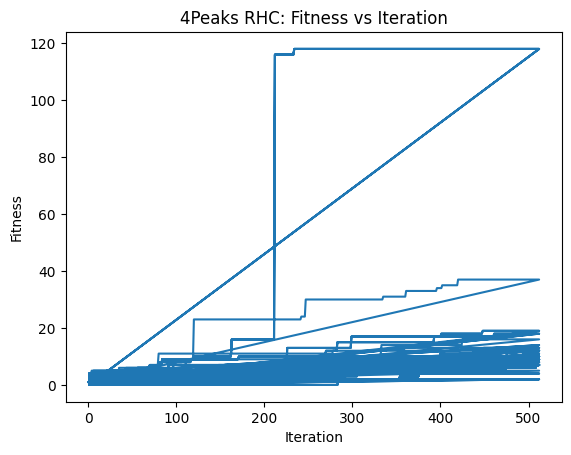

In [12]:
# Example of plotting results
plt.figure()
plt.plot(rhc_run_curves['Iteration'], rhc_run_curves['Fitness'])
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.title('4Peaks RHC: Fitness vs Iteration')
plt.show()

#### RHCRunner with 3 seeds and averaging over runs to determine best hyperparams 

In [6]:
seed_list = [55, 12345, 888]

In [7]:
# Define the hyperparameters
max_attempts = 200
restart_list = [0, 1, 2, 4, 8, 16, 32, 64]

In [9]:
# Function to run RHCRunner with a specific seed
def run_rhc_with_seed(seed, max_attempts, restart_list):
    rhc_runner = RHCRunner(
        problem=fourpeaks_problem,
        experiment_name="4peaks_rhc_experiment",
        output_directory=f"./output_seed_{seed}",
        seed=seed,
        iteration_list=2 ** np.arange(10), #specific points (iterations) at which performance metrics are measured 
        max_attempts=max_attempts, #max number of attempts algo will make to find improvement in fitness value before terminating current run
        restart_list=restart_list #resets the algo from a new random initial state 
    )
    return rhc_runner.run()

# Run RHCRunner for each seed and collect results
all_run_stats = []
all_run_curves = []

for seed in tqdm(seed_list, desc="Running RHCRunner with different seeds"):
    rhc_run_stats, rhc_run_curves = run_rhc_with_seed(seed, max_attempts, restart_list)
    all_run_stats.extend(rhc_run_stats)
    all_run_curves.extend(rhc_run_curves)

# Convert the results to a DataFrame for analysis
rhc_run_stats_df = pd.DataFrame(all_run_stats)

Running RHCRunner with different seeds: 100%|████| 3/3 [33:17<00:00, 665.70s/it]


KeyError: 'Iteration'

In [11]:
rhc_run_stats

,Iteration,Fitness,FEvals,Time,State,Restarts,max_iters,current_restart
0,0,3.0,0,0.000145,"[0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, ...",0,512,0
1,1,3.0,1,0.006826,"[0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, ...",0,512,0
2,2,3.0,2,0.013514,"[0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, ...",0,512,0
3,4,3.0,4,0.018354,"[0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, ...",0,512,0
4,8,3.0,8,0.022667,"[0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, ...",0,512,0
...,...,...,...,...,...,...,...,...
1480,32,2.0,26516,488.728610,"[0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, ...",64,512,64
1481,64,2.0,26548,489.574267,"[0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, ...",64,512,64
1482,128,2.0,26612,490.857941,"[0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, ...",64,512,64
1483,256,16.0,26743,493.106865,"[0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, ...",64,512,64


In [14]:
# Calculate average performance metrics
average_fitness = rhc_run_stats.groupby('Iteration')['Fitness'].mean()
average_time = rhc_run_stats.groupby('Iteration')['Time'].mean()

print("Average Fitness over Iterations:")
print(average_fitness)

print("Average Time over Iterations:")
print(average_time)

# Find the best hyperparameters based on average performance
best_run = rhc_run_stats.loc[rhc_run_stats.groupby('Iteration')['Fitness'].idxmax()]
print("Best Hyperparameters:")
print(best_run)

Average Fitness over Iterations:
Iteration
0       1.785185
1       1.785185
2       1.785185
4       1.807407
8       1.896296
16      2.125926
32      2.844444
64      3.274074
128     4.792593
256     8.000000
512    11.014815
Name: Fitness, dtype: float64
Average Time over Iterations:
Iteration
0      106.213402
1      106.463752
2      106.704265
4      106.947112
8      107.213485
16     107.492968
32     107.821252
64     108.247091
128    108.881785
256    109.814847
512    110.951735
Name: Time, dtype: float64
Best Hyperparameters:
      Iteration  Fitness  FEvals        Time  \
682           0      5.0   10475   84.100269   
683           1      5.0   10476   84.451009   
684           2      5.0   10477   84.793508   
366           4      5.0    5436   19.897937   
686           8      6.0   10484   85.619137   
1171         16     12.0   14992  193.446776   
1172         32     12.0   15008  193.943817   
1173         64     12.0   15040  194.814487   
1339        128     1

**Restarts** means that it begins the optimization process from a new, randomly selected initial state after completing a run either because it reached the max number of attempts without finding an improvement or it converged to a local optimum. This is done to escape potential local optima and explore other parts of the solution space. 

The process: 
- algo is initialized from the seed state. it performs the hill climbing process
- that run terminates when either max_attempts is reached (no improvement was found) or algo converged, which means no better neighboring state was found within the allowed attempts
- the algo then selects a new random initial state and repeats the hill climbing process

Example: at restarts=64, the algo performs 64 independent runs, each starting from a different random initial state. 

**Intuition about 4peaks and restarts**
- 4peaks likely has multiple local optima. Restarts are pivotal in ensuring that the algo doesn't get stuck in these local optima and prevent it from finding the global optimum.
- 4peaks has a lot of peaks and valleys, and benefits from exploratory behavior by starting from multiple random points so that the chance of finding a better solution is increased. A single run from one initial point is insufficient to thoroughly explore the solution space.
- having multiple restarts ensures better coverage for the solution space. however, computational time suffers so a trade-off has to be made between having more restarts and a desire for shorter computational time.
- can analyze RHC fitness scores on different number of restarts, and plot the fitness scores against the restarts to see how quickly the algo converges to better solutions with those additional restarts.

Average Fitness by Restarts:
Restarts
0     3.545455
1     4.000000
2     4.454545
4     4.472727
8     4.414141
16    4.112299
32    3.550964
64    3.545455
Name: Fitness, dtype: float64


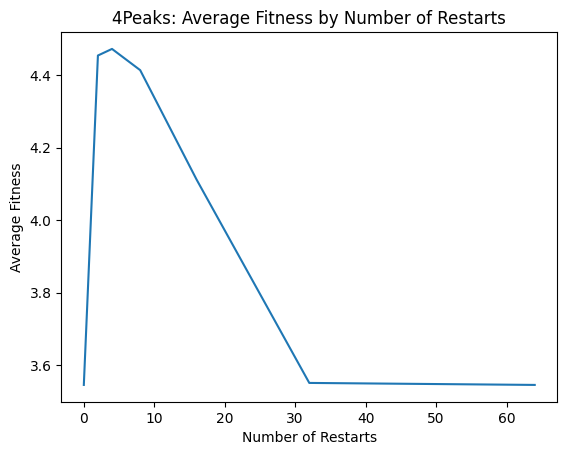

In [16]:
# Calculate average performance metrics
average_fitness = rhc_run_stats.groupby('Restarts')['Fitness'].mean()

print("Average Fitness by Restarts:")
print(average_fitness)

# Plot the average fitness by restarts
plt.plot(average_fitness)
plt.title('4Peaks: Average Fitness by Number of Restarts')
plt.xlabel('Number of Restarts')
plt.ylabel('Average Fitness')
plt.show()